In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.linalg as la

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:
np.zeros([3,3])

array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]])

In [9]:
?np.linalg.solve

Signature:       np.linalg.solve(a, b)
Call signature:  np.linalg.solve(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function solve at 0x7c5720d67560>
File:            ~/Documents/QuantumInspiredML/QuantumInspiredML/.conda/lib/python3.12/site-packages/numpy/linalg/linalg.py
Docstring:      
Solve a linear matrix equation, or system of linear scalar equations.

Computes the "exact" solution, `x`, of the well-determined, i.e., full
rank, linear matrix equation `ax = b`.

Parameters
----------
a : (..., M, M) array_like
    Coefficient matrix.
b : {(..., M,), (..., M, K)}, array_like
    Ordinate or "dependent variable" values.

Returns
-------
x : {(..., M,), (..., M, K)} ndarray
    Solution to the system a x = b.  Returned shape is identical to `b`.

Raises
------
LinAlgError
    If `a` is singular or not square.

See Also
--------
scipy.linalg.solve : Similar function in SciPy.

Notes
-----

.. versionadded:: 1.8.0

Broadcasting rules apply, see the `nu

In [7]:
?np.einsum


Signature:       np.einsum(*operands, out=None, optimize=False, **kwargs)
Call signature:  np.einsum(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function einsum at 0x7c57217e6340>
File:            ~/Documents/QuantumInspiredML/QuantumInspiredML/.conda/lib/python3.12/site-packages/numpy/core/einsumfunc.py
Docstring:      
einsum(subscripts, *operands, out=None, dtype=None, order='K',
       casting='safe', optimize=False)

Evaluates the Einstein summation convention on the operands.

Using the Einstein summation convention, many common multi-dimensional,
linear algebraic array operations can be represented in a simple fashion.
In *implicit* mode `einsum` computes these values.

In *explicit* mode, `einsum` provides further flexibility to compute
other array operations that might not be considered classical Einstein
summation operations, by disabling, or forcing summation over specified
subscript labels.

See the notes and examples for clarification.

Par

In [14]:
def buildf0(x,sigma,x0):
    f0 = np.exp(-(x -0.5)**2/2/sigma**2)# np.exp(-(x-x0)**2/2/sigma**2) + 2*np.exp(-(x-0.5)**2/2/0.7**2) + np.exp(-(x+0.6)**2/2/0.8**2) 
    dx = x[1]-x[0]
    return f0/np.sqrt(np.sum(f0**2)*dx)

def buildfn(x,f0,n,cVecs):
    func = np.zeros_like(x)
    for i in range(0,n+1):
        func += cVecs[n,i]*x**i*f0
        
    return func

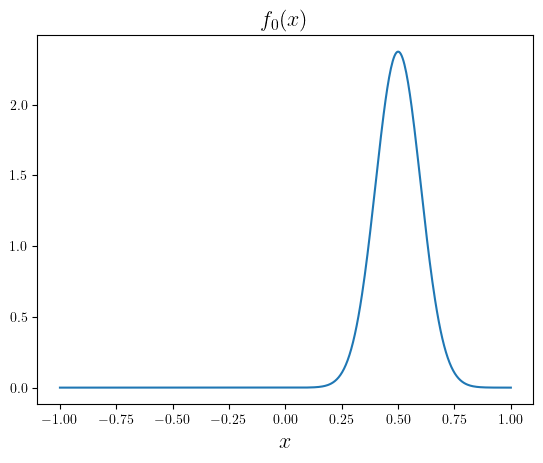

1.0

In [15]:
x = np.linspace(-1,1,501)
dx=x[1]-x[0]
sigma=0.1
x0=0.1

f0 = buildf0(x,sigma,x0)

plt.plot(x, f0)
plt.xlabel('$x$',fontsize=16)
plt.title(r'$f_0(x)$',fontsize=16)
plt.show()

sum(f0**2)*dx  #check normalisation

In [31]:
N=3 # get new orthogonal basis functions from 1 to N-1
dx=x[1]-x[0]
cVecs = np.zeros([N+1,N+1]) # rows are the n (order of f) and columns are the i (order of the polynomial in the sum to make f)
cVecs[0,0] = 1 #c_00 is always 1

#Build the matrix of overlaps. (This is really only a vector, but it's convenient to build it as a matrix like this)
Mij = np.zeros([N+1,N+1])
for i in range(0, N+1):
    for j in range(0, N+1):
        Mij[i,j] = sum(x**(i+j)*f0**2)*dx

#now we iterate and get the functions
for n in range(0,N):
        if n==0:
            #special case of getting the f1 function from the f0 function
            cVecs[1,0]=1 #set the first c value to 1
            cVecs[1,1] = -1/Mij[1,0] #get the second c value
            norm = np.einsum('ij,i,j',Mij[0:2,0:2],cVecs[1,0:2],cVecs[1,0:2]) #normalise the function in terms of its c values
            cVecs[1,:] = cVecs[1,:]/np.sqrt(norm) # renormalise the c values
            
        else:
            deltaVecTemp = np.zeros(n+1) # build the vector representing the kronecker delta on LHS of notes
            MijTemp = Mij[0,0:n+1] # get M_0j
            cVecTemp = np.einsum('mj,j->m',cVecs[0:n+1,0:n+1],MijTemp) # get c_mj
        
            # Now build Mij cmj on RHS, which is the matrix we want to invert
            MijTemp = Mij[1:n+2,0:n+1]
            Aij = np.einsum('mj,ij->mi',cVecs[0:n+1,0:n+1],MijTemp)
        
            #now solve the problem
            inhomo = deltaVecTemp - cVecTemp #the inhomogeneous term
            cVecSol = np.linalg.solve(Aij, inhomo) #solve the linear problem
            cVecs[n+1,0] = 1 #set c_0 to 1
            for i in range(1, n+2):
                cVecs[n+1,i] = cVecSol[i-1] #use solutions to define new entries
            norm = np.einsum('ij,i,j',Mij[0:n+2,0:n+2],cVecs[n+1,0:n+2],cVecs[n+1,0:n+2]) #Normalise the new basisfunction
            cVecs[n+1,:] = cVecs[n+1,:]/np.sqrt(norm) #renormalise the new basis function using the new cvecs
            

In [32]:
print(np.array_str(cVecs, precision=4, suppress_small=True))

[[    1.         0.         0.         0.    ]
 [    7.0711   -14.1421     0.         0.    ]
 [   34.6482  -141.4214   141.4214     0.    ]
 [  135.6773  -848.7049  1732.0508 -1154.7005]]


In [37]:
f1 = buildfn(x,f0,1,cVecs)
f2 = buildfn(x,f0,2,cVecs)
f3 = buildfn(x,f0,3,cVecs)
# f4 = buildfn(x,f0,4,cVecs)
# f5 = buildfn(x,f0,5,cVecs)

In [45]:
f2.shape

(501,)

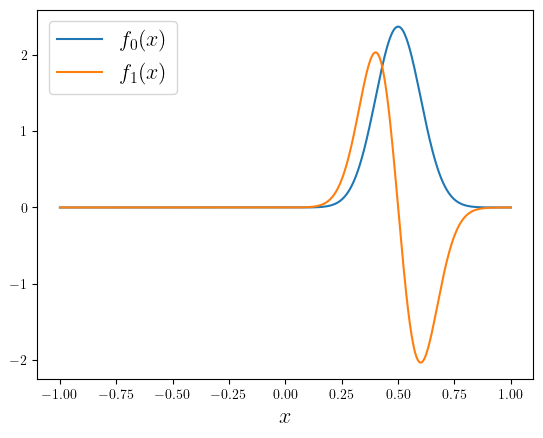

In [47]:
plt.plot(x,f0, label=r'$f_0(x)$')
plt.plot(x,f1, label=r'$f_1(x)$')
# plt.plot(x,f2, label=r'$f_2(x)$')
# plt.plot(x,f3, label=r'$f_3(x)$')
#plt.plot(x,f4)
#plt.plot(x,f5)
plt.xlabel(r'$x$',fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [14]:
#Check orthogonality

print(sum(f1*f2)*dx)
print(sum(f1*f3)*dx)
print(sum(f1*f4)*dx)
print(sum(f1*f5)*dx)

print(sum(f2*f3)*dx)
print(sum(f2*f4)*dx)
print(sum(f2*f5)*dx)

print(sum(f3*f4)*dx)
print(sum(f3*f5)*dx)

print(sum(f4*f5)*dx)


-2.389199948993339e-16
-1.0222933610748451e-15
5.382361223382764e-16
-1.803002191991256e-15
8.721912081455238e-16
2.7249313916399866e-15
1.6413537196058329e-15
1.0800249583553532e-15
-5.979217121421249e-15
-5.14788212058193e-15


In [15]:
#Check normalisation

print(sum(f1*f1)*dx)
print(sum(f2*f2)*dx)
print(sum(f3*f3)*dx)
print(sum(f4*f4)*dx)
print(sum(f5*f5)*dx)


0.9999999999999988
1.000000000000002
0.9999999999999959
1.0000000000000044
1.0000000000000042
